# This notebook is to explore if Ohmnet preserves the relationship of the nodes in the subnetwork like the original network

In [3]:
import sys
sys.path.append("../..")
from src.eda.eda_functions import jaccard_similarity
import platform
import pandas as pd
import numpy as np
import os
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances as ed
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

# Prepare data for Ohmnet

In [4]:
subnet1 = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\eda_derived\subnetworks_Jan_14\deg_mod=[4],non_deg_mod=[],num_genes=250,min_weight=0.008.csv', index_col = 0)

In [8]:
# convert df from adjacency to edgelist
subnet1.values[tuple([np.arange(len(subnet1))]*2)] = np.nan
subnet1_edge = subnet1.stack().reset_index()

In [9]:
le = LabelEncoder()
le.fit(subnet1.columns)
subnet1_edge.level_0 = le.transform(subnet1_edge.level_0) # convert gene id to number to work with Ohmnet
subnet1_edge.level_1 = le.transform(subnet1_edge.level_1)

LabelEncoder()

In [356]:
subnet1_edge = subnet1_edge[subnet1_edge['level_0'].isin([2627, 2999, 2319])] # take only 3 source genes

In [169]:
subnet1_edge = subnet1_edge[subnet1_edge[0] > 0.012] # and subset with weight > 0.012
subnet1_edge.to_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv', index = 0)

In [316]:
subnet1_edge = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv')

In [ ]:
# Then subnet1_edge is split into 2 dataframes with 12 genes + edges (source and target are the same) overlap 
# The 2 dataframes are then fed to Ohmnet to embed

In [320]:
# edge1 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist1.txt', sep = '\t', header= None)
# edge2 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist2.txt', sep = '\t', header= None)

In [324]:
## check how many nodes overlap betwen these two sub-subnetwork
# len(set(edge1[1]).intersection(edge2[1]))

258

# Determine closest genes in the network and in the Ohmnet output

In [325]:
# ohmnet output (embedding)
data = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\tmp\internal_vectors.emb', sep = ' ', skiprows=1, header = None, index_col = 0)

In [326]:
data_index = list(data.index)
new_index = list(map(lambda x:int(x.split('__')[1]), data_index))
data.index = new_index
data = data.reset_index()

In [360]:
def get_closest_genes_jaccard(network, ohmnet_emb, top_n):
    ed_df = ed(ohmnet_emb, ohmnet_emb)
    closest_genes1 = [] # find closest genes in the subnetwork
    closest_genes2 = [] # find closest genes in the embedding
    for gene in network.level_0.unique():
        closest_genes1.append(network[network.level_0 == gene].sort_values('0', ascending = False)['level_1'][:top_n])
        gene_index = ohmnet_emb[ohmnet_emb['index'] == gene].index[0]
        top_n_index = ed_df[gene_index].argsort()[1:top_n+1]
        closest_genes2.append(ohmnet_emb.loc[top_n_index]['index'])
    jac_list = []
    for i in range(len(closest_genes1)):
        jac_list.append(jaccard_similarity(closest_genes1[i], closest_genes2[i]))
    xticks = le.inverse_transform(subnet1_edge.level_0.unique())
    plt.rcParams.update({'font.size':18})
    plt.bar(xticks, jac_list)
    plt.ylim(0, 1)
    plt.ylabel('Jaccard similarity')
    plt.xlabel('gene')
    plt.xticks(rotation = 45, ha = 'right')
    plt.title('Jaccard closest genes');

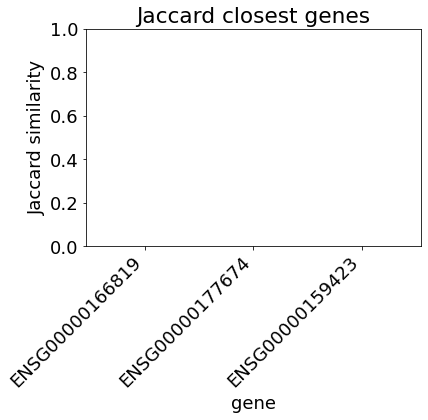

In [361]:
get_closest_genes_jaccard(subnet1_edge, data, 10)

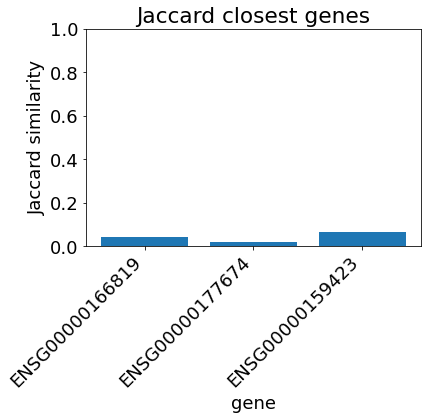

In [362]:
get_closest_genes_jaccard(subnet1_edge, data, 50)

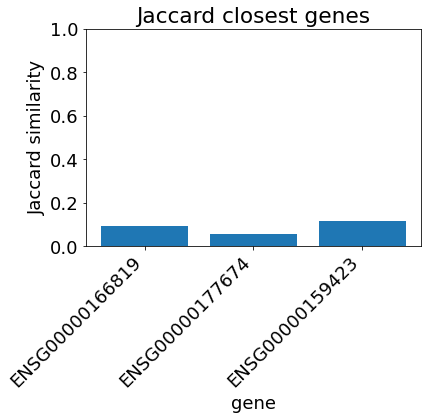

In [363]:
get_closest_genes_jaccard(subnet1_edge, data, 100)